In [1]:
import os
import numpy as np
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 
import tensorflow as tf
import keras
from glob import glob
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, Activation, Conv2DTranspose, LeakyReLU, Flatten, Dense, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(os.getcwd())

/home/masterlx/python-projects/MammothInteractiveLearning


In [2]:
# Check if TensorFlow can access a GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("TensorFlow can access the following GPUs:")
    for gpu in gpus:
        print(gpu)
else:
    print("TensorFlow cannot access any GPUs.")

TensorFlow can access the following GPUs:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
path_to_train_photos   = '/mi_source_003/Source Files/00 Dataset/Dataset/train/train_photo/'

path_to_train_sketches = '/mi_source_003/Source Files/00 Dataset/Dataset/train/train_sketch/'

path_to_test_photos    = '/mi_source_003/Source Files/00 Dataset/Dataset/test/test_photo/'

path_to_test_sketches  = '/mi_source_003/Source Files/00 Dataset/Dataset/test/test_sketch/'



train_photos   = [os.getcwd()+path_to_train_photos+i for i in os.listdir(os.getcwd()+path_to_train_photos) if 'DS_Store' not in i]

train_sketches = [os.getcwd()+path_to_train_sketches+i for i in os.listdir(os.getcwd()+path_to_train_sketches)]

test_photos    = [os.getcwd()+path_to_test_photos+i for i in os.listdir(os.getcwd()+path_to_test_photos) if 'DS_Store' not in i]

test_sketches  = [os.getcwd()+path_to_test_sketches+i for i in os.listdir(os.getcwd()+path_to_test_sketches)]

photos   = train_photos + test_photos 

sketches = train_sketches + test_sketches



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


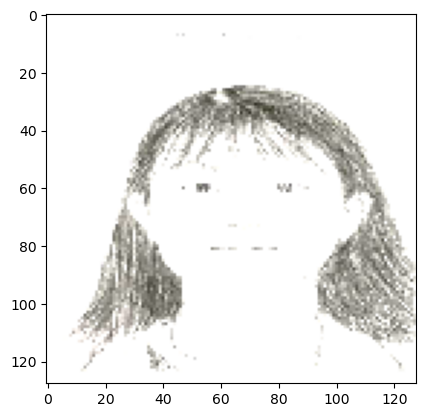

In [4]:
img = load_img(sketches[5], target_size=(128,128,3))
img_array = img_to_array(img)

# Display the image
plt.imshow(img_array/128)

In [5]:
# def prepare_dataset(sketch_paths, photo_paths, batch_size=32):
#     def load_and_preprocess_image(path):
#         img = tf.io.read_file(path)
#         img = tf.image.decode_jpeg(img, channels=3)
#         img = tf.image.resize(img, [128, 128])
#         img = (tf.cast(img, tf.float32) - 127.5) / 127.5
#         return img

#     # Create datasets for sketches and photos
#     sketch_dataset = tf.data.Dataset.from_tensor_slices(sketch_paths)
#     photo_dataset = tf.data.Dataset.from_tensor_slices(photo_paths)

#     # Map preprocessing function to each image
#     sketch_dataset = sketch_dataset.map(lambda x: load_and_preprocess_image(x), num_parallel_calls=tf.data.AUTOTUNE)
#     photo_dataset = photo_dataset.map(lambda x: load_and_preprocess_image(x), num_parallel_calls=tf.data.AUTOTUNE)

#     # Zip the datasets together
#     dataset = tf.data.Dataset.zip((sketch_dataset, photo_dataset))

#     # Shuffle, batch, and prefetch
#     dataset = dataset.shuffle(10000)
#     dataset = dataset.batch(batch_size)
#     dataset = dataset.prefetch(tf.data.AUTOTUNE)

#     return dataset

def prepare_dataset(sketch_paths, photo_paths, batch_size=32):
    def load_and_preprocess_image(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [128, 128])
        # Normalize to [-1, 1] range for GANs
        img = (tf.cast(img, tf.float32) - 127.5) / 127.5
        return img

    # Create datasets for sketches and photos
    sketch_dataset = tf.data.Dataset.from_tensor_slices(sketch_paths)
    photo_dataset = tf.data.Dataset.from_tensor_slices(photo_paths)

    # Map preprocessing function to each image
    sketch_dataset = sketch_dataset.map(lambda x: load_and_preprocess_image(x), num_parallel_calls=tf.data.AUTOTUNE)
    photo_dataset = photo_dataset.map(lambda x: load_and_preprocess_image(x), num_parallel_calls=tf.data.AUTOTUNE)

    # Zip the datasets together
    dataset = tf.data.Dataset.zip((sketch_dataset, photo_dataset))

    # Shuffle, batch, and prefetch
    dataset = dataset.shuffle(10000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [6]:
def generator():
    input_layer = Input((128, 128, 3))
    
    # Encoder
    x = Conv2D(32, (7,7), strides=(1,1), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # Downsampling
    x = Conv2D(64, (3,3), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # Residual blocks
    for _ in range(6):
        res = x
        x = Conv2D(128, (3,3), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(128, (3,3), padding='same')(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([res, x])
    
    # Upsampling
    x = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # Output
    output = Conv2D(3, (7,7), strides=(1,1), padding='same', activation='tanh')(x)
    
    return Model(inputs=[input_layer], outputs=[output])

def discriminator():
    input_layer = Input((128, 128, 3))
    
    x = Conv2D(64, (4,4), strides=(2,2), padding='same')(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, (4,4), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(256, (4,4), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(512, (4,4), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # x = Conv2D(1, (4,4), strides=(1,1), padding='same')(x)
    
    x = Flatten()(x)
    output = Dense(1, activation='sigmoid')(x)
    
    
    return Model(inputs=[input_layer], outputs=[output])

In [7]:
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

# def gradient_penalty_loss(y_true, y_pred, averaged_samples, discriminator):
#     with tf.GradientTape() as tape:
#         tape.watch(averaged_samples)  # Watch the input for gradient calculation
#         y_pred_tape = discriminator(averaged_samples, training=True)  # Pass samples through the discriminator
    
#     # Compute gradients of the discriminator output w.r.t. the averaged samples
#     gradients = tape.gradient(y_pred_tape, averaged_samples)
    
#     # Compute the L2 norm of the gradients
#     gradients_sqr = tf.square(gradients)
    
#     # Reduce sum along all dimensions except the first (batch dimension)
#     gradients_sqr_sum = tf.reduce_sum(gradients_sqr, axis=list(range(1, tf.rank(gradients_sqr))))
#     gradient_l2_norm = tf.sqrt(gradients_sqr_sum)
    
#     # Compute the gradient penalty
#     gradient_penalty = tf.square(1 - gradient_l2_norm)
    
#     return tf.reduce_mean(gradient_penalty)

def gradient_penalty_loss(y_true, y_pred, averaged_samples, discriminator):
    with tf.GradientTape() as tape:
        tape.watch(averaged_samples)  # Watch the input for gradient calculation
        y_pred_tape = discriminator(averaged_samples, training=True)  # Pass samples through the discriminator
    
    # Compute gradients of the discriminator output w.r.t. the averaged samples
    gradients = tape.gradient(y_pred_tape, averaged_samples)
    
    # Compute the L2 norm of the gradients
    gradients_sqr = tf.square(gradients)
    
    # Explicitly reduce sum along all dimensions except the first (batch) dimension
    gradients_sqr_sum = tf.reduce_sum(gradients_sqr, axis=list(range(1, tf.rank(gradients_sqr).numpy())))
    gradient_l2_norm = tf.sqrt(gradients_sqr_sum)
    
    # Compute the gradient penalty
    gradient_penalty = tf.square(1 - gradient_l2_norm)
    
    return tf.reduce_mean(gradient_penalty)

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
outputs = [vgg.get_layer(name).output for name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']]
vgg_model = Model([vgg.input], outputs)

def perceptual_loss(y_true, y_pred):

    f_true = vgg_model(y_true)
    f_pred = vgg_model(y_pred)
    loss = 0
    for ft, fp in zip(f_true, f_pred):
        loss += tf.reduce_mean(tf.square(ft - fp))
    return loss

def combined_generator_loss(y_true, y_pred):
    adv_loss = wasserstein_loss(y_true, y_pred)
    perc_loss = perceptual_loss(y_true, y_pred)
    l1_loss = tf.reduce_mean(tf.abs(y_true - y_pred))
    return adv_loss + 10*perc_loss + 100*l1_loss

In [16]:
def train_step(sketch_batch, photo_batch, generator, discriminator, gen_optimizer, disc_optimizer):
    batch_size = tf.shape(sketch_batch)[0]
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(sketch_batch, training=True)
        
        real_output = discriminator(photo_batch, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # Wasserstein loss
        gen_loss = -tf.reduce_mean(fake_output)
        disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
        
        # Gradient penalty
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        interpolated = alpha * photo_batch + (1 - alpha) * generated_images
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            interp_output = discriminator(interpolated, training=True)
        
        grads = gp_tape.gradient(interp_output, [interpolated])[0]
        grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=list(range(1, tf.rank(grads)))))
        gradient_penalty = tf.reduce_mean(tf.square(1.0 - grad_norm))
        disc_loss += 10.0 * gradient_penalty  # 10 is a common weight for GP

        # Perceptual loss for generator
        perc_loss = perceptual_loss(photo_batch, generated_images)
        gen_loss += 10.0 * perc_loss  # Scale perceptual loss appropriately
    
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Clip gradients to avoid explosion
    gen_gradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gen_gradients]
    disc_gradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in disc_gradients]
    
    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# Main training loop
def train(dataset, epochs, gen, discrim):
    
    
    gen_optimizer = Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
    disc_optimizer = Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
    
    for epoch in range(epochs):
        for sketch_batch, photo_batch in dataset:
            gen_loss, disc_loss = train_step(sketch_batch, photo_batch, gen, discrim, gen_optimizer, disc_optimizer)
        
        print(f"Epoch {epoch+1}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")
        
        # Save generated images periodically
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(gen, epoch + 1, sketch_batch)

# Function to generate and save images
def generate_and_save_images(model, epoch, test_input, output_dir = os.getcwd()+'/model_outputs'):
    predictions = model(test_input, training=False)
    
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Create a figure
    fig = plt.figure(figsize=(4, 4))

    # Number of images to display in the grid
    num_images = min(predictions.shape[0], 16)  # Display a 4x4 grid (max 16 images)

    for i in range(num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] * 0.5) + 0.5)  # Rescale to [0, 1]
        plt.axis('off')
    
    # Save the generated image
    output_path = os.path.join(output_dir, f'image_at_epoch_{epoch:04d}.png')
    plt.savefig(output_path)
    plt.close()

    print(f"Image saved at {output_path}")

In [18]:
dataset = prepare_dataset(sketches, photos, batch_size=16)
gen = generator()
discrim = discriminator()
# Start training
train(dataset, epochs=1000, gen=gen,discrim=discrim)

Epoch 1, Gen Loss: 3573.2310, Disc Loss: 0.2336
Epoch 2, Gen Loss: 3064.1348, Disc Loss: 1.4569
Epoch 3, Gen Loss: 2832.6035, Disc Loss: 0.4697
Epoch 4, Gen Loss: 2651.5369, Disc Loss: 1.2109
Epoch 5, Gen Loss: 2600.8145, Disc Loss: 4.4484
Epoch 6, Gen Loss: 2458.9155, Disc Loss: 2.5286
Epoch 7, Gen Loss: 2277.7971, Disc Loss: -0.0852
Epoch 8, Gen Loss: 2064.1514, Disc Loss: 1.2525
Epoch 9, Gen Loss: 2222.9651, Disc Loss: 0.3471
Epoch 10, Gen Loss: 1967.0597, Disc Loss: 1.0663
Image saved at /home/masterlx/python-projects/MammothInteractiveLearning/model_outputs/image_at_epoch_0010.png
Epoch 11, Gen Loss: 2106.6990, Disc Loss: 3.4216
Epoch 12, Gen Loss: 1812.7191, Disc Loss: 0.5522
Epoch 13, Gen Loss: 1874.4180, Disc Loss: 1.4852
Epoch 14, Gen Loss: 1991.2151, Disc Loss: 0.1001
Epoch 15, Gen Loss: 2041.6403, Disc Loss: 3.1604
Epoch 16, Gen Loss: 1933.1942, Disc Loss: 2.0676
Epoch 17, Gen Loss: 1877.6085, Disc Loss: 0.6971
Epoch 18, Gen Loss: 1962.7540, Disc Loss: 1.5263
Epoch 19, Gen L

1/1 [==============================] - 0s 236ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


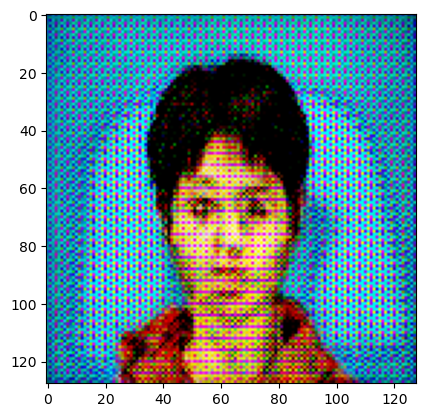

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


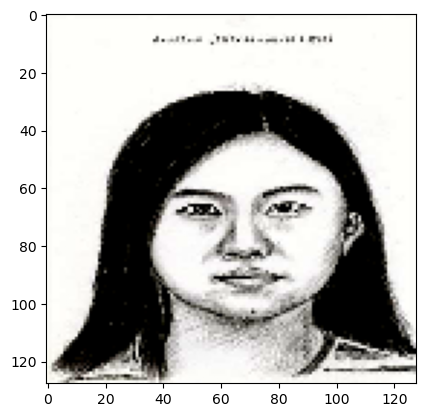

In [19]:
test_path  = os.getcwd()+'/mi_source_003/Source Files/00 Dataset/Dataset/test/test_sketch/f-039-01-sz1.jpg'

test_image = load_img(test_path, target_size=(128, 128, 3))

test_image = img_to_array(test_image)

test_image = (test_image.astype(np.float32) - 127.5) / 127.5

zeros_array = np.zeros((1, 128, 128, 3))

zeros_array[0] = test_image.astype(np.float32)

result_photo = gen.predict(zeros_array)


plt.imshow(result_photo[0])
plt.show()
plt.imshow(test_image)
plt.show()